# Optimization for Machine Learning PA 3

**due December 2nd 2022**

This homework assignment investigates implementing *variance reduced* stochastic gradient descent. This is a relatively recent innovation (for example, see [this paper](https://papers.nips.cc/paper/2013/hash/ac1dd209cbcc5e5d1c6e28598e8cbbe8-Abstract.html) from NeurIPS 2013) on the standard SGD that is effective for minimizing *finite sum* objectives of the form:
$$
\mathcal{L}(w) = \frac{1}{N}\sum_{i=1}^N \ell(w,z_i)
$$
The original analyses only worked for smooth convex losses, although it has since been extended to the non-convex case (see [here](https://arxiv.org/abs/1807.01695), and [here](https://arxiv.org/abs/1806.07811) for two papers that independently and simultaneously co-discovered the optimal rates in the non-convex setting).

The basic algorithm is often called SVRG for stochastic variance-reduced gradient descent. In this homework, you will implement SVRG and test it on a linear classification task. In this setting, $N$ is the size of the training set and $\mathcal{L}(w)$ is the training loss.

This homework re-uses some code from the first programming assignment. In particular, you we will be comparing SVRG to the adaptive SGD algorithm from the first programming assigment. A working copy of that optimizer is included for you so you do not need to re-implement it.


There are **3** questions on this homework, corresponding to different parts of the SVRG implementation. The first two involve implementing helper functions `update_checkpoint_gradient` and `compute_variance_reduced_gradients`. The last involves implementing the training loop for SVRG.

To turn in this homework: download as .ipynb (File -> download as .ipynb). Make the filename YOURNAME_HW3.ipynb and upload to Gradescope. Your submission should have **all cells run to completion**. When testing your code, you may wish to change the notebook to run only some subset of the training runs at the end: the reference solution takes around 30 minutes to finish all 8 runs in the last cell. To help you compare your performance, the output of the reference implementation has been left in this notebook. 

In [1]:
#imports
import torch, torchvision
import torchvision.transforms as transforms
from torch.optim import Optimizer
import numpy as np
from matplotlib import pyplot as plt
from collections.abc import Iterable
import torch.nn as nn
import torch.nn.functional as F

# Adaptive SGD implementation

The following cell contains a working implementation of an SGD algorithm with an adaptive learning rate. You do NOT need to modify this cell.

In [2]:
class SGD_adaptive(Optimizer):
  def __init__(self, params, lr=1.0):
    super(SGD_adaptive, self).__init__(params, {'lr': lr})

    for group in self.param_groups:
      for param in group['params']:
        state = self.state[param]
        state['step'] = 0

        # make a dictionary entry for Gt. It is just a 1-D vector (a scalar).
        # device=p.device tells pytorch to allocate the memory for Gt on the 
        # same device (e.g. CPU or GPU) as the data for the variable p.
        state['Gt'] = torch.zeros(1, device=param.device)

  @torch.no_grad()
  def step(self, closure=None):
    loss = None
    if closure is not None:
      with torch.enable_grad():
        loss = closure()

    for group in self.param_groups:
      lr = group['lr']
      for param in group['params']:
        if param.grad is None:
          continue

        # Update the iteration counter (again, this is not actually used in this algorithm)
        state = self.state[param]
        state['step'] += 1
        step = state['step']

        grad = param.grad

        state['Gt'].add_(torch.norm(grad)**2)
        
        param.addcdiv_(grad, torch.sqrt(state['Gt']), value=-lr)


# Implementing SVRG

**SVRG with adaptive learning rates**

The SVRG algorithm we discussed in class performs the following scheme:
1. generate a "checkpoint gradient" $\nabla \mathcal{L}(v)$ at a point $v$ using a full pass over the training set.
2. Run a full pass over the training set using SGD update with the "variance reduced" gradients:
$$
g_t = \nabla \ell(w_t, z_t) - \nabla \ell(v, z_t) + \nabla \mathcal{L}(v)
$$
3. Set a new checkpoint parameter $v$ to be the *average* of the iterates produced in step 2, then go back to step 1 and repeat.

We will call the full passes "epochs", and we will say that that we are in an "SGD phase" if the epoch is happening in step 2, vs a "checkpoint phase" if the epoch is happening in step 1.

You will produce a modified version of SVRG that incorporates a few tricks to improve the performance in practice.
* Your implementation will allow for larger minibatch-sizes, so the variance-reduced gradient updates will be:
$$
g_t = \frac{1}{B}\sum_{i=1}^B\nabla \ell(w_t, z_{t,i}) - \frac{1}{B}\sum_{i=1}^B\nabla \ell(v, z_{t,i}) + \nabla \mathcal{L}(v)
$$
This part does not actually require any work on your part - pytorch will automatically provide you with the minibatch gradient values $\frac{1}{B}\sum_{i=1}^B\nabla \ell(w_t, z_{t,i})$ and $\frac{1}{B}\sum_{i=1}^B\nabla \ell(v, z_{t,i})$.
* After each full pass over the training set in the SGD phase, you will set the next checkpoint $v$ to be the **last** iterate rather than the average of the iterates.
* You will incorporate adaptive learning rates:
$$
\eta_t = \frac{lr}{\sqrt{\sum_{\tau=1}^t \|g_\tau\|^2}}
$$
where $lr$ is a user-specified constant. Notice that the $g_t$ here is the variance-reduced gradient estimate rather than the simple minibatch-estimate used when computing the adaptive learning rate we discussed in lecture and implemented in the `SGD_adaptive` class provided above in this homework.

Please read the provided code for the SVRG optimizer carefully. The code consists of a main training loop in `train_model_svrg` as well as helper functions `zero_grad`, `update_checkpoint_gradient`, `compute_variance_reduced_gradients` and `update_checkpoint_model`.

You will need to implement most of `update_checkpoint_gradient` and `compute_variance_reduced_gradients`. `zero_grad` and `update_checkpoint_model` are implemented for you. You will also need to write code in `train_model_svrg` to compute full gradients and do sgd steps with variance reduced gradients using the helper functions.

<br>

**Question 1: Implement `update_checkpoint_gradient`**

**Question 2: Implement `compute_variance_reduced_gradients`**

<br>


When you have implemented `update_checkpoint_gradient` and `compute_variance_reduced_gradients`, please run the testing code in the cells directly after the implementation. These should print a "looks good" message when your code works correctly. 

<br>

**Question 3: Finish implementing `train_model_svrg`**

There are TWO places marked ###YOUR CODE HERE###  in `train_model_svrg`. You need to fill out both of them. Read through the rest of the training loop code, and the comments around where your code should be placed to understand what is required.

<br>


When you finish implementing `train_model_svrg`, run the following cells in the notebook. This will compare SGD to SVRG, where you should see that SVRG with a learning rate of 10 outperforms SGD.

The SVRG implementation will re-use the `SGD_adaptive` optimizer by modifying the `p.grad` attribute of all parameters `p` in the model to equal variance reduced gradien estimates rather than the original non-variance reduced gradients produced by `.backward()`.

`train_model_svrg` keeps track of the checkpoint parameters in a separate pytorch model called `checkpoint_model`. It stores the model that is actually being optimized in `primary_model`. There are also several dictionaries that help keep track of the correspondences between these models that are defined at the beginning of `train_model_svrg`. 


See https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py for some similar example of how to set up the process below, from which much of this was copied.

In [3]:
## These commands create two pytorch "DataLoader" objects, one for training
# data and one for testing data.
# A DataLoader object is essentially a list of training/testing examples with
# some extra code attached by pytorch that can send the data to GPUs and other
# useful things.

# The following three commands produce a torchvision dataset object for both
# training and testing data on the CIFAR10 dataset, which is a dataset of images.
# these objects are like lists of vectors (the "transform" specifies a function
# that converts images to vectors").
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     torch.nn.Flatten(start_dim=0)
     ])
CIFAR_train = torchvision.datasets.CIFAR10(root='CIFAR10/', train=True, download=True, transform=transform)
CIFAR_test = torchvision.datasets.CIFAR10(root='CIFAR10/', train=False, transform=transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10/


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)


cuda:0


In [5]:
# We will consider a linear classifier. The classifier will first normalize the features to have norm 1
# and then multiply by a matrix w to obtain scores for each class, which will eventually
# be evaluated using softmax and cross-entropy loss.
class LinearClassifier(nn.Module):
    def __init__(self, d_feature=32*32*3, n_classes=10):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(d_feature, n_classes)


        with torch.no_grad():
          # initialize weight to zero
          self.linear.weight.zero_()
          self.linear.bias.zero_()
        
    def forward(self, x):
        scores = self.linear(x)
        return scores

# Questions 1 and 2

Question 1 and 2 both require you to edit the cell below.

In [7]:
## Please read this code to understand how the two gradients are computed for SVRG. ##
def zero_grad(checkpoint_model):
  '''
  zeros out the gradient of all parameters in a model.
  Similar to optimizer.zero_grad, but doesn't require an optimizer (and is also
  a bit simpler).
  '''
  for p in checkpoint_model.parameters():
    p.grad = None

def update_checkpoint_gradient(train_loader,
                               device,
                               loss_function,
                               primary_model,
                               checkpoint_model,
                               primary_model_to_checkpoint,
                               full_checkpoint_grads):
  '''
  This function should store the gradient from a full pass over the dataset
  in the dictionary full_checkpoint_grads.
  It should also return the number of minibatches in the dataset.

  Arguments:
    train_loader: pytorch dataloader object for iterating over the training set.
      The data is presented as (inputs, labels) where inputs can be sent as 
      input to the model to get predictions.
    
    device: the device (cpu or cuda:0) where the model weights are located.

    loss_function: a function that compute loss:
      loss = loss_function(predictions, labels)

    primary_model: the pytorch model we are actually optimizing (whose parameters are the actual iterates SVRG)

    checkpoint_model: a pytorch model whose parameters are at the checkpoint values.

    primary_model_to_checkpoint: a dictionary whose keys are the parameters for the model that
      is actually being optimized, and values are the corresponding parameters of the checkpoint model.

    full_checkpoint_grads: a dictionary whose keys are the parameters for the model
      that we are actually optimizing and values should be filled out with gradients
      on the full dataset. It is *highly recommended* that you update these values *in place*
      as this will be quite a bit faster.

  returns:
    count: an integer that tells how many examples (not minibatches!) were contained in the dataloader.
  
  side effect:
    modifies the dictionary full_checkpoint_grads so that for every parameter p in model.parameters()
      full_checkpoint_grads[p] = average gradient of loss at checkpoint parameters over entire dataset.
  '''

  count = 0
  total_minibatches = 0
  for p in full_checkpoint_grads:
      full_checkpoint_grads[p].zero_()

  for i, data in enumerate(train_loader):
    ## YOUR CODE HERE FOR QUESTION 1 ###
    
    inputs, label = data
    inputs, label = inputs.to(device), label.to(device)

    # count += label.size(0)
    count += inputs.shape[0]
    total_minibatches += 1

    # predicted_labels = primary_model.forward(inputs)
    predicted_labels = checkpoint_model(inputs)
    loss = loss_function(predicted_labels, label)

    # tell pytorch to compute some gradients
    loss.backward()
    # for para in checkpoint_model.parameters():
    #   full_checkpoint_grads[para] = para.grad
    full_checkpoint_grads[primary_model.linear.weight] += checkpoint_model.linear.weight.grad
    full_checkpoint_grads[primary_model.linear.bias] += checkpoint_model.linear.bias.grad
    
    zero_grad(checkpoint_model)

    ### END STUDENT CODE FOR QUESTION 1###

  for p in full_checkpoint_grads:
    full_checkpoint_grads[p].div_(total_minibatches)

  

  return count
      

def compute_variance_reduced_gradients(inputs,
                                       labels,
                                       loss_function,
                                       primary_model,
                                       primary_model_to_checkpoint,
                                       checkpoint_model,
                                       full_checkpoint_grads):
  '''
  computes the variance reduced gradient estimate of the loss using minibatch example
  data (inputs, labels) with respect to the parameters in primary_model.

  The variance reduced gradient estimate is:
  g = \nabla loss(minibatch, parameter) - \nabla loss(minibatch, checkpoint_param) + \nabla full_training_loss(checkpoint_param)

  For each parameter p in primary_model.parameters(), you should compute the variance reduced gradient
  and store it in p.grad.

  You might need to recall that the .backward() function in pytorch will compute a (non variance reduced) gradient and 
  store it in the .grad attribute.

  Arguments:
    inputs: the input features, shape [B, D] where B is minibatch size and D is feature dimension.
  
    labels: the labels, shape [B]

    loss_function: the loss function, should take two arguments: model predictions and labels (i.e. loss_function(predictions, labels) )

    primary_model: a pytorch model object holding the model we are optimizing. You can get predictions with primary_model(inputs)

    primary_model_to_checkpoint: a dictionary whose keys are parameters in the primary model and whose values are parameters in the checkpoint model.
      That is, for all p in primary_model.parameters(), primary_model_to_checkpoint[p] is the corresponding parameter in checkpoint_model.

    checkpoint_model: a pytorch model object holding the parameters at the checkpoint.

    full_checkpoint_grads: a dictionary whose keys are parameters in the primary model and whose values are the gradient of the full loss at the checkpoint.
      that is, full_checkpoint_grads[p] is the gradient of the full training loss at the checkpoint value.
  
  Returns:
    loss: the loss of the primary model at the current minibatch.
  '''
  ### YOUR CODE HERE FOR QUESTION 2 ###
  # compute primary model loss
  predicted_labels1 = primary_model(inputs.to(device))
  loss1 = loss_function(predicted_labels1, labels.to(device))
  loss1.backward()

  l1_wg = primary_model.linear.weight.grad
  l1_bg = primary_model.linear.bias.grad
  zero_grad(primary_model)

  # compute checkpoint model loss
  predicted_labels2 = checkpoint_model(inputs.to(device))
  loss2 = loss_function(predicted_labels2, labels.to(device))
  loss2.backward()

  l2_wg = checkpoint_model.linear.weight.grad
  l2_bg = checkpoint_model.linear.bias.grad
  zero_grad(checkpoint_model)

  # compute the third term
  all_wg = full_checkpoint_grads[primary_model.linear.weight]
  all_bg = full_checkpoint_grads[primary_model.linear.bias]

  #update gradient
  primary_model.linear.weight.grad = l1_wg - l2_wg + all_wg
  primary_model.linear.weight.bias = l1_bg - l2_bg + all_bg
  
  return loss1
  ### END STUDENT CODE FOR QUESTION 2 ###


@torch.no_grad()
def update_checkpoint_model(primary_model_to_checkpoint):
  '''
  Copies parameter values from the primary model to the checkpoint model.

  arguments:
    primary_model_to_checkpoint: dictionary whose keys are primary model parameters
      and values are corresponding checkpoint model parameters.
  
  returns:
    nothing
  
  side effects:
    the checkpoint model parameters will be changed to equal the primary model parameters.
  '''

  for p in primary_model_to_checkpoint:
    primary_model_to_checkpoint[p].copy_(p)


# Testing cell for question 1

In [8]:
# this cell will test your implementation of update_checkpoint_gradient
# Do NOT modify this cell (although you may make a copy and modify the copy
# for debuggin purposes).
def test_update_checkpoint_gradient(batch_size):
  weight = np.array([[0.0, 1.0, 0.0],
                    [1.0, 0.0, 1.0]], dtype=np.float32)
  np_feature = np.array([[ 0.6,   0.8,   0.0],
                        [ 0.8,   0.0,   0.6],
                        [-0.8,  -0.6,   0.0],
                        [ 0.0,  -0.8,  -0.6]], dtype=np.float32)

  labels_one_hot = [[1, 0],
                    [1, 0],
                    [0, 1],
                    [0, 1]]

  # compute gradients (shape annotations written after calculations)
  scores = np_feature @ weight.transpose() # [N, D] @ [D, C] -> [N, C]
  np_grads = np_feature.transpose() @ (scores - labels_one_hot) / 4 # [D, N] @ [N, C] -> [D, C]

  np_grads_bias = np.sum((scores - labels_one_hot), axis=0) / 4 # [N, C] -> [C]

  features = torch.tensor(np_feature)

  labels = torch.tensor([0, 0, 1, 1])

  train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(features, labels), batch_size=batch_size)

  def loss_function(scores, labels):
    labels = torch.nn.functional.one_hot(labels, num_classes=2)
    loss = 0.5 * torch.sum(torch.square(scores-labels)) / labels.size(0)
    return loss

  primary_model = LinearClassifier(d_feature=3, n_classes=2)
  with torch.no_grad():
    primary_model.linear.weight.copy_(torch.tensor(weight))

  primary_model.to(device)

  checkpoint_model = LinearClassifier(d_feature=3, n_classes=2)
  checkpoint_model.load_state_dict(primary_model.state_dict())
  checkpoint_model.to(device)

  primary_model_to_checkpoint = {p_p: c_p for p_p, c_p in zip(primary_model.parameters(), checkpoint_model.parameters())}
  checkpoint_to_primary_model = {c_p: p_p for p_p, c_p in zip(primary_model.parameters(), checkpoint_model.parameters())}

  # we initialize full_checkpoint grads to 1s here to make sure your code doesn't accumulate with old gradients
  full_checkpoint_grads = {p: torch.ones_like(p) for p in primary_model.parameters()}

  examples = update_checkpoint_gradient(train_loader,
                                        device,
                                loss_function,
                                primary_model,
                                checkpoint_model,
                                primary_model_to_checkpoint,
                                full_checkpoint_grads)
  
  assert examples == 4

  try:
    assert np.allclose(np_grads.transpose(), full_checkpoint_grads[primary_model.linear.weight].cpu())
  except AssertionError:
    print(f"gradient check for weight was wrong for batch size {batch_size}!: ")
    print("correct gradient: ", np_grads.transpose())
    print("your gradient: ", full_checkpoint_grads[primary_model.linear.weight].cpu())
    raise AssertionError

  try:
    assert np.allclose(np_grads_bias, full_checkpoint_grads[primary_model.linear.bias].cpu())
  except AssertionError:
    print(f"gradient check for bias was wrong! for batch size {batch_size}: ")
    print("correct gradient: ", np_grads_bias)
    print("your gradient: ", full_checkpoint_grads[primary_model.linear.bias].cpu())
    raise AssertionError

for bs in [1, 2, 4]:
  test_update_checkpoint_gradient(bs)

print("full batch gradient looks good!")


full batch gradient looks good!


# Testing cell for Question 2

In [9]:
# this cell will test your implementation of compute_vr_gradient
# Do NOT modify this cell (although you may make a copy and modify the copy
# for debuggin purposes).
def test_compute_vr_gradient(batch_size):
  weight = np.array([[0.0, 1.0, 0.0],
                    [1.0, 0.0, 1.0]], dtype=np.float32)
  np_feature = np.array([[ 0.6,   0.8,   0.0],
                        [ 0.8,   0.0,   0.6],
                        [-0.8,  -0.6,   0.0],
                        [ 0.0,  -0.8,  -0.6]], dtype=np.float32)

  labels_one_hot = [[1, 0],
                    [1, 0],
                    [0, 1],
                    [0, 1]]

  ##### compute gradients analytically (shape annotations written after calculations)
  scores = np_feature @ weight.transpose() # [N, D] @ [D, C] -> [N, C]
  np_full_grad = (np_feature.transpose() @ (scores - labels_one_hot)).transpose() / 4 # [D, N] & [N, C] -> [D, C]

  np_full_grad_bias = np.sum((scores - labels_one_hot), axis=0) / 4 # [N, C] -> [C]
  #####


  # # set up test dataset
  # features = torch.tensor(np_feature)
  # labels = torch.tensor([0, 0, 1, 1])
  # train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(features, labels), batch_size=batch_size)

  def loss_function(scores, labels):
    labels = torch.nn.functional.one_hot(labels, num_classes=2)
    loss = 0.5 * torch.sum(torch.square(scores-labels)) / labels.size(0)
    return loss


  # define primary and checkpoint models and relevant dictionaries
  primary_model = LinearClassifier(d_feature=3, n_classes=2)
  with torch.no_grad():
    primary_model.linear.weight.copy_(torch.tensor(weight))

  primary_model.to(device)

  checkpoint_model = LinearClassifier(d_feature=3, n_classes=2)
  checkpoint_model.load_state_dict(primary_model.state_dict())
  checkpoint_model.to(device)

  primary_model_to_checkpoint = {p_p: c_p for p_p, c_p in zip(primary_model.parameters(), checkpoint_model.parameters())}
  checkpoint_to_primary_model = {c_p: p_p for p_p, c_p in zip(primary_model.parameters(), checkpoint_model.parameters())}


  # initial full_checkpoint_grads with correct gradients:
  full_checkpoint_grads = {p: torch.ones_like(p) for p in primary_model.parameters()}
  with torch.no_grad():
    full_checkpoint_grads[primary_model.linear.weight].copy_(torch.tensor(np_full_grad))
    full_checkpoint_grads[primary_model.linear.bias].copy_(torch.tensor(np_full_grad_bias))


  # change model weights so that primary and checkpoint models are at different points.
  new_weight = np.array([[0.0, 0.0, 1.0],
                        [0.0, 1.0, 1.0]])
  with torch.no_grad():
    primary_model.linear.weight.copy_(torch.tensor(new_weight))

  # set up test dataset, extract first minibatch:
  features = torch.tensor(np_feature)
  labels = torch.tensor([0, 0, 1, 1])
  train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(features, labels), batch_size=batch_size)
  # train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(features, labels), batch_size=batch_size)

  test_inputs, test_labels = iter(train_loader).__next__()
  test_inputs = test_inputs.to(device)
  test_labels = test_labels.to(device)


  loss = compute_variance_reduced_gradients(test_inputs,
                                    test_labels,
                                    loss_function,
                                    primary_model,
                                    primary_model_to_checkpoint,
                                    checkpoint_model,
                                    full_checkpoint_grads)

  ###### compute variance reduced gradient analytically
  np_test_inputs =  test_inputs.cpu().numpy()
  np_test_labels = torch.nn.functional.one_hot(test_labels, num_classes=2).cpu().numpy()
  test_scores = np_test_inputs @ new_weight.transpose()
  np_primary_grad = (np_test_inputs.transpose() @ (test_scores - np_test_labels)).transpose() / batch_size

  checkpoint_test_scores = np_test_inputs @ weight.transpose()
  np_checkpoint_grad = (np_test_inputs.transpose() @ (checkpoint_test_scores - np_test_labels)).transpose() / batch_size

  np_grad = np_primary_grad - np_checkpoint_grad + np_full_grad
  #####



  try:
    assert np.allclose(np_grad, primary_model.linear.weight.grad.cpu().detach())
  except AssertionError:
    print(f"gradient check for weight was wrong for batch size {batch_size}!: ")
    print("correct gradient: ", np_grad.transpose())
    print("your gradient: ", primary_model.linear.weight.grad.cpu().detach())
    raise AssertionError
 

for bs in [1, 2, 4]:
  test_compute_vr_gradient(bs)

print("variance reduced gradient looks good!")

variance reduced gradient looks good!


# Training loop for SGD

This cell contains a training loop for SGD. You should NOT modify this cell, but you may read it to see how it works.

In [10]:
## This cell contains a training loop for SGD. You do not need to
# modify anything here.

def train_model_sgd(train_loader, device, lr, num_epochs):
  '''
  Trains a linear classifier on CIFAR10 data using SGD.

  args:
    train_loader: pytorch DataLoader object that provides the training examples.
    device: pytorch device to use (e.g. a GPU).
    lr: learning rate.
    num_epochs: number of epochs to train for.

  returns:
    model, losses
    model: the trained pytorch model object.
    losses: a sequence pairs of [num_examples, loss] representing the loss and
      total number of examples seen so far over trainingof losses produced over training.
  '''

  model = LinearClassifier()
  model.to(device)
  losses = []


  # define \ell as the cross-entropy function.
  # this function as implemented in pytorch actually combines both the softmax
  # and the cross entropy function into one. As a result, it is
  # is non-negative, smooth, Lipschitz, and convex in its argument, which
  # are the predicted scores for various classes output by some model.
  cross_entropy_loss = torch.nn.CrossEntropyLoss()

  optimizer = SGD_adaptive(model.parameters(), lr)


  running_average_loss = 0.0
  total_examples = 0

  for epoch in range(num_epochs):
    # iterate over training set.

    for i, data in enumerate(train_loader):
      # unpack the example data: inputs is a batch of images,
      # labels is a batch of labels.
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      total_examples += labels.size(0)

      # pytorch will keep details from old gradients around in case you are going
      # to differentiate something else. We therefore need to delete this old
      # data before computing the loss so that we only have the gradient
      # for this iteration.
      optimizer.zero_grad()

      predicted_labels = model.forward(inputs)
      loss = cross_entropy_loss(predicted_labels, labels)

      # tell pytorch to compute some gradients
      loss.backward()


      optimizer.step()

      

      running_average_loss += (loss.item() - running_average_loss)/(i+1)
      losses.append([total_examples, loss.item()])


    print('[After epoch %d] loss: %.3f' %
          (epoch + 1, running_average_loss))
    running_average_loss = 0.0

  print('Finished Training')

  return model, np.array(losses)


# Question 3: training loop for SVRG

Please finish the TWO places in this cell marked ### YOUR CODE HERE ##

In [11]:
### Training loop for SVRG. You will need to finish this function.


def train_model_svrg(train_loader, device, lr, num_epochs, svrg=False):
  '''
  Trains a linear classifier on CIFAR10 data using SVRG

  args:
    train_loader: pytorch DataLoader object that provides the training examples.
    device: pytorch device to use (e.g. a GPU).
    lr: learning rate.
    num_epochs: number of epochs to train for.

  returns:
    model, losses
    model: the trained pytorch model object.
    losses: a sequence pairs of [num_examples, loss] representing the loss and
      total number of examples seen so far over training of losses produced over training.
  '''

  primary_model = LinearClassifier()
  primary_model.to(device)
  losses = []

  checkpoint_model = LinearClassifier()
  checkpoint_model.load_state_dict(primary_model.state_dict())
  checkpoint_model.to(device)

  primary_model_to_checkpoint = {p_p: c_p for p_p, c_p in zip(primary_model.parameters(), checkpoint_model.parameters())}
  checkpoint_to_primary_model = {c_p: p_p for p_p, c_p in zip(primary_model.parameters(), checkpoint_model.parameters())}

  full_checkpoint_grads = {p: torch.zeros_like(p) for p in primary_model.parameters()}

  total_examples = 0


  # define \ell as the cross-entropy function.
  # this function as implemented in pytorch actually combines both the softmax
  # and the cross entropy function into one. As a result, it is
  # is non-negative, smooth, Lipschitz, and convex in its argument, which
  # are the predicted scores for various classes output by some model.
  cross_entropy_loss = torch.nn.CrossEntropyLoss()


  optimizer = SGD_adaptive(primary_model.parameters(), lr)


  average_loss = 0.0

  for epoch in range(num_epochs):
    # iterate over training set num_epochs times.
    # NOTE: computing a full gradient is considered an epoch.
    # So, if num_epochs is 3, then we should do one epoch of SGD,
    # one epoch of computing a full gradient, and then one final epoch of SGD.


    if epoch % 2 == 0:
      ### YOUR CODE HERE FOR QUESTION 3 ###
      # Implement a full-gradient computation, storing the results in the
      # dictionary full_checkpoint_grads.
      # your code should also increment total_examples by the number of 
      # examples in one epoch.
      examples = update_checkpoint_gradient(train_loader,
                                            device,
                                            cross_entropy_loss,
                                            primary_model,
                                            checkpoint_model,
                                            primary_model_to_checkpoint,
                                            full_checkpoint_grads)

      total_examples += examples
      ### END STUDENT CODE ###
    else:
      for i, data in enumerate(train_loader):
        # unpack the example data: inputs is a batch of images,
        # labels is a batch of labels.
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        total_examples += labels.size(0)

        ### YOUR CODE HERE FOR QUESTION 3 ###

        # Implement the SGD phase of SVRG.
        # at the end of this code block, you should have taken one step of SGD
        # using a variance reduced gradient estimate on the minibatch (inputs, labels).
        # You should also create a Tensor called "loss" that will hold the loss
        # of the primary model on the current minibatch.

        # note that for the first epoch, the SGD phase is identitcal to the non-variance
        # reduced algorithm since we have not yet computed a checkpoint gradient.
        # for subsequent epochs however the behavior is different.
        optimizer.zero_grad()
        loss = compute_variance_reduced_gradients(inputs,
                                                  labels,
                                                  cross_entropy_loss,
                                                  primary_model,
                                                  primary_model_to_checkpoint,
                                                  checkpoint_model,
                                                  full_checkpoint_grads)
        optimizer.step()



        # raise NotImplementedError

        
        ### END STUDENT CODE ###

        average_loss += (loss.item() - average_loss)/(i+1)

        losses.append([total_examples, loss.item()])



      print('[After epoch %d] loss: %.3f' %
            (epoch+1, average_loss))
      average_loss = 0.0
    

  print('Finished Training')

  return primary_model, np.array(losses)


In [12]:
def get_trainloader(batch_size):
  trainloader = torch.utils.data.DataLoader(CIFAR_train, batch_size=batch_size,
                                            shuffle=True)
  return trainloader


**Testing the implementation**
Now, for each learning rate in [0.1, 10, 100] and a minibatch size of 10, we will check the performance of both the adaptive SGD and your SVRG implementation after 10 epochs. The best performance for SGD should be with learning rate 1.0, with a final training loss of roughly 1.66. For SVRG, the best learning rate should be 10, with a final training loss of roughly 1.57.

Note that there are two asserts in this cell that will check that you have correctly recorded the total number of examples in Question 3.

In [13]:
batch_size = 10
num_epochs = 10
lr_list = [0.1, 1.0, 10.0, 100.0]
trained_models_svrg = {}
trained_models_sgd = {}
losses_svrg = {}
losses_sgd = {}
for lr in lr_list:
  print("Training models with learning rate: {}".format(lr))
  trainloader = get_trainloader(batch_size)
  print("Training SVRG")
  trained_models_svrg[lr], losses_svrg[lr] = train_model_svrg(trainloader, device, lr=lr, num_epochs=num_epochs)
  assert len(losses_svrg[lr]) == (50000 * num_epochs // batch_size) // 2, f"incorrect losses_svrg len: was {len(losses_svrg[lr])}, expected {(50000 * num_epochs // batch_size) //2}!"
  assert losses_svrg[lr][-1,0] == 50000 * num_epochs, f"incorrect total_examples: was {losses_svrg[lr][-1,0]}, expected {50000 * num_epochs}!"
  print("Training SGD")
  trained_models_sgd[lr], losses_sgd[lr] = train_model_sgd(trainloader, device, lr=lr, num_epochs=num_epochs)

Training models with learning rate: 0.1
Training SVRG
[After epoch 2] loss: 1.796
[After epoch 4] loss: 1.762
[After epoch 6] loss: 1.751
[After epoch 8] loss: 1.744
[After epoch 10] loss: 1.738
Finished Training
Training SGD
[After epoch 1] loss: 1.868
[After epoch 2] loss: 1.806
[After epoch 3] loss: 1.788
[After epoch 4] loss: 1.777
[After epoch 5] loss: 1.770
[After epoch 6] loss: 1.764
[After epoch 7] loss: 1.759
[After epoch 8] loss: 1.755
[After epoch 9] loss: 1.752
[After epoch 10] loss: 1.749
Finished Training
Training models with learning rate: 1.0
Training SVRG
[After epoch 2] loss: 1.733
[After epoch 4] loss: 1.688
[After epoch 6] loss: 1.676
[After epoch 8] loss: 1.670
[After epoch 10] loss: 1.665
Finished Training
Training SGD
[After epoch 1] loss: 1.800
[After epoch 2] loss: 1.718
[After epoch 3] loss: 1.699
[After epoch 4] loss: 1.689
[After epoch 5] loss: 1.682
[After epoch 6] loss: 1.677
[After epoch 7] loss: 1.673
[After epoch 8] loss: 1.669
[After epoch 9] loss: 1.6

Next, we will plot a smoothed version of the loss as a function of number of training examples processed. You should observe characteristic "flat" regions for SVRG, followed by faster decreasing SGD periods.

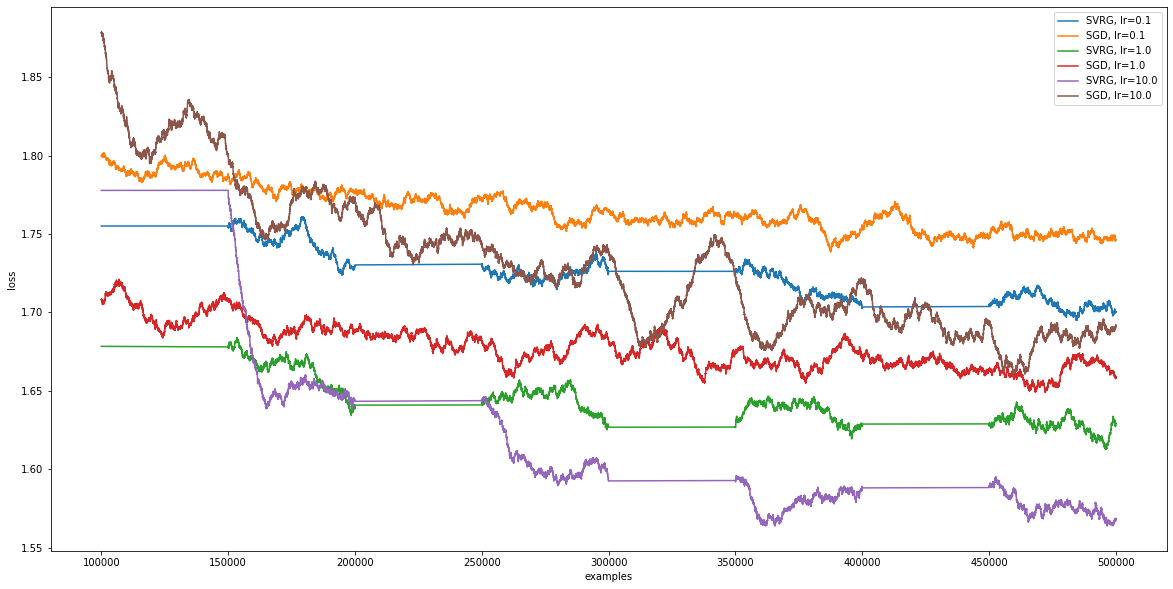

In [ ]:
def running_mean(x, N):
  '''
  computes a windowed-average running mean of a list of numbers.

  arguments:
    x: numpy array to compute running mean over
    N: window size.

  returns:
    numpy array with windowed-average running mean. Note that if len(x) = K,
    the return value will have length K - N + 1
  '''

  cumsum = np.cumsum(np.insert(x, 0, 0)) 
  return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.rcParams["figure.figsize"] = (20,10)
N = 1500
for lr in [0.1, 1.0, 10.0]:

  plt.plot(losses_svrg[lr][:,0][5000-1:],running_mean(losses_svrg[lr][:,1][5000-N:], N), label=f"SVRG, lr={lr}")
  plt.plot(losses_sgd[lr][:,0][10000-1:],running_mean(losses_sgd[lr][:,1][10000-N:], N), label=f"SGD, lr={lr}")
plt.ylabel('loss')

plt.xlabel('examples')
plt.legend()
plt.show()

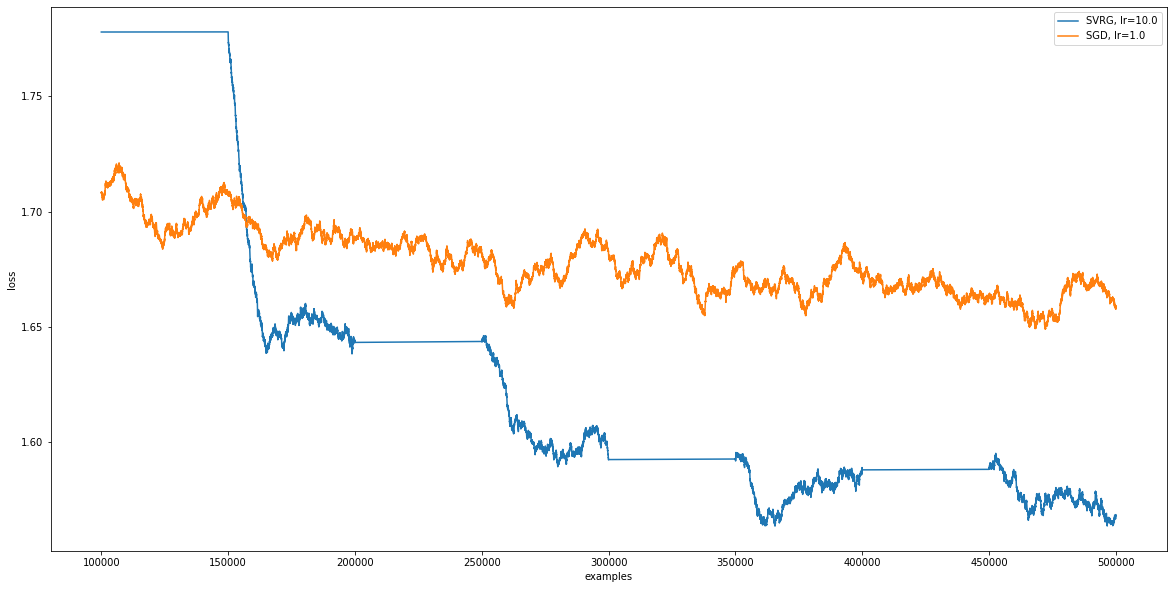

In [ ]:

plt.rcParams["figure.figsize"] = (20,10)
N = 1500
plt.plot(losses_svrg[lr][:,0][5000-1:],running_mean(losses_svrg[10.0][:,1][5000-N:], N), label=f"SVRG, lr=10.0")
plt.plot(losses_sgd[lr][:,0][10000-1:],running_mean(losses_sgd[1.0][:,1][10000-N:], N), label=f"SGD, lr=1.0")
plt.ylabel('loss')

plt.xlabel('examples')
plt.legend()
plt.show()